# Constructing Quantum Oracles for 3-Coloring Problems via NP-Reduction

In this notebook, we demonstrate how to easily construct quantum oracles for [3-Coloring problems](https://en.wikipedia.org/wiki/Graph_coloring) using Qiskit Aqua via simple NP-Reduction to [SAT problems](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem).

3-Coloring is the decision problem of determining whether a graph's vertices can be colored using only 3 different colors s.t. no neighboring vertices share the same color. SAT is also a decision problem where we want to see if an 
given conjunctive normal form (CNF) has a satisfying assignment.

Aqua already provides an `LogicExpressionOracle` class capable of building Quantum Oracle circuits from arbitrary logic expressions, with support for the [DIMACS CNF format](https://www.satcompetition.org/2009/format-benchmarks2009.html). So, to take advantage of that, we in this notebook aim to reduce 3-coloring problems to SAT problems, and then directly use the `LogicExpressionOracle` class to build the Oracle circuit.

For 3-coloring problem instances, we work with the [DIMACS graph coloring format](https://mat.tepper.cmu.edu/COLOR/instances.html), which basically indicates the number of vertices and edges on the `'p edge'` line, followed by the `'e'` lines listing all edges (vertex pairs). For example we can have the following toy instance, and easily parse it.

In [1]:
three_coloring_instance = '''
c This is an example DIMACS 3-coloring file
p edge 3 3
e 1 2
e 1 3
e 2 3
'''

import itertools

def parse_3_coloring_instance(instance):
    ls = [
        l.strip() for l in instance.split('\n')
        if len(l) > 0 and not l.strip()[0] == 'c'
    ]
    headers = [l for l in ls if l[0] == 'p']
    if len(headers) == 1:
        p, sig, nv, ne = headers[0].split()
        assert p == 'p' and sig == 'edge'
    elif len(headers) > 1:
        raise RuntimeError('Invalid input format for 3-Coloring.')
    h_nv, h_ne = int(nv), int(ne)
    edges = [[int(v) for v in l.split()[1:]] for l in ls if l[0] == 'e']
    nv = len(set(list(itertools.chain.from_iterable(edges))))
    ne = len(edges)
    if not h_nv == nv:
        print((
            'Warning: inaccurate vertex count {} in header. '
            'Actual vertex count is {}.'
        ).format(h_nv, nv))
    if not h_ne == ne:
        print((
            'Warning: inaccurate edge count {} in header. '
            'Actual edge count is {}.'
        ).format(h_ne, ne))

    return nv, ne, edges

nv, ne, edges = parse_3_coloring_instance(three_coloring_instance)

print('The input 3-coloring instance has {} vertices and {} edges: {}.'.format(nv, ne, edges))

The input 3-coloring instance has 3 vertices and 3 edges: [[1, 2], [1, 3], [2, 3]].


For any 3-coloring problem instance, we can use the following simple strategy to reduce it to a SAT problem:

- For each vertex $v$, we create three boolean variables $v_r$, $v_g$, and $v_b$, corresponding to the vertex $v$ being of color red, green, and blue, respectively.
- For each vertex $v$, we then have the constraint that it needs to be of one and only one color. Therefore, $v_r \vee v_g \vee v_b = True$, and $v_i \wedge v_j = False$ for $i,j \in \{r,g,b\}, i \ne j$.
- For each edge $(v, t)$, we have the constraint that they cannot both be of the same color. Therefore, $v_i \wedge t_i = False$ for $i \in \{r, g, b\}$.

With this simple strategy and the help of the [De Morgan's Law](https://en.wikipedia.org/wiki/De_Morgan%27s_laws), we can carry out the reduction as follows.

In [2]:
def reduce_to_sat(nv, ne, edges):

    def _get_vertex_rgb(v):
        return 3 * v - 2, 3 * v - 1, 3 * v

    def _get_vertex_constraints(v):
        r, g, b = _get_vertex_rgb(v)
        return [
            '{0} {1} {2} 0'.format(r, g, b),
            '{} {} 0'.format(-r, -g),
            '{} {} 0'.format(-r, -b),
            '{} {} 0'.format(-g, -b)
        ]

    def _get_edge_constraints(v1, v2):
        r1, g1, b1 = _get_vertex_rgb(v1)
        r2, g2, b2 = _get_vertex_rgb(v2)
        return [
            '{0} {1} 0'.format(-r1, -r2),
            '{0} {1} 0'.format(-g1, -g2),
            '{0} {1} 0'.format(-b1, -b2)
        ]

    buf = list()
    buf.append('p cnf {0} {1}'.format(nv * 3, nv * 4 + ne * 3))
    buf.extend(itertools.chain.from_iterable([
        _get_vertex_constraints(v)
        for v in range(1, nv + 1)])
    )
    buf.extend(itertools.chain.from_iterable([
        _get_edge_constraints(v1, v2)
        for v1, v2 in edges])
    )
    return '\n'.join(buf)

sat_instance_cnf = reduce_to_sat(nv, ne, edges)
print('The input 3-Coloring instance can be reduced to the following SAT instance:\n\n{}'.format(sat_instance_cnf))

The input 3-Coloring instance can be reduced to the following SAT instance:

p cnf 9 21
1 2 3 0
-1 -2 0
-1 -3 0
-2 -3 0
4 5 6 0
-4 -5 0
-4 -6 0
-5 -6 0
7 8 9 0
-7 -8 0
-7 -9 0
-8 -9 0
-1 -4 0
-2 -5 0
-3 -6 0
-1 -7 0
-2 -8 0
-3 -9 0
-4 -7 0
-5 -8 0
-6 -9 0


Now we have successfully reduced the 3-Coloring problem instance to its equivalent SAT instance, we can go ahead using Aqua's `LogicExpressionOracle` to build the oracle and construct the quantum circuit.

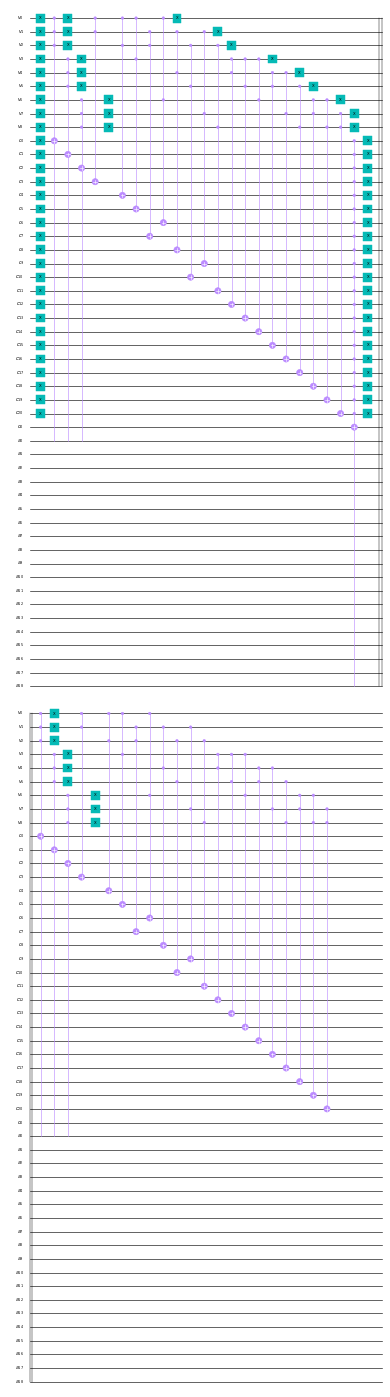

In [3]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle

oracle = LogicalExpressionOracle(expression=sat_instance_cnf)
oracle.circuit.draw(output='mpl', scale=0.3)